<a href="https://colab.research.google.com/github/Capstone-Team-CH2-PS379/Machine-Learning/blob/main/ASR-model/CTC_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [4]:
pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 10.1 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer

# Load Dataset

In [6]:
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

2748572632/2748572632 [==============================] - 68s 0us/step


In [7]:
# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(10)

,file_name,normalized_transcription
0,LJ009-0289,and before he took to hanging he was employed ...
1,LJ003-0130,"His wife visited him in Newgate, and wrote a p..."
2,LJ018-0118,a system which had long been in practice of de...
3,LJ007-0091,The lunatic became the sport of the idle and t...
4,LJ006-0298,while older women in infirm health were sent a...
5,LJ037-0220,Approximately fifteen minutes before the shoot...
6,LJ048-0091,Advance preparations.
7,LJ017-0111,"that his friend had died greatly embarrassed, ..."
8,LJ044-0029,It appears to have been a solitary operation o...
9,LJ028-0439,for none of the many building inscriptions fro...


In [8]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

metadata_df.head(10)

,file_name,normalized_transcription
0,LJ009-0289,and before he took to hanging he was employed ...
1,LJ003-0130,"His wife visited him in Newgate, and wrote a p..."
2,LJ018-0118,a system which had long been in practice of de...
3,LJ007-0091,The lunatic became the sport of the idle and t...
4,LJ006-0298,while older women in infirm health were sent a...
5,LJ037-0220,Approximately fifteen minutes before the shoot...
6,LJ048-0091,Advance preparations.
7,LJ017-0111,"that his friend had died greatly embarrassed, ..."
8,LJ044-0029,It appears to have been a solitary operation o...
9,LJ028-0439,for none of the many building inscriptions fro...


In [ ]:
num_of_samples = 5000
metadata_df = metadata_df[:num_of_samples]

# Split data into training and validation set
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")

Size of the training set: 4500
Size of the validation set: 500


# Data Pre-processing

In [ ]:
# The set of characters accepted in the transcription.
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' '] (size =31)


In [ ]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalization
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [ ]:
batch_size = 32
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE).padded_batch(batch_size)
.prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Check and Visualize the Dataset

In [ ]:
name = df_train["file_name"]
wav_file = name[1]

file = tf.io.read_file(wavs_path + wav_file + ".wav")
audio, _ = tf.audio.decode_wav(file)

audio = tf.squeeze(audio, axis=-1)
audio = tf.cast(audio, tf.float32)

spectrogram = tf.signal.stft(
    audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
)

spectrogram = tf.abs(spectrogram)
spectrogram = tf.math.pow(spectrogram, 0.5)

means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
spectrogram = (spectrogram - means) / (stddevs + 1e-10)

In [ ]:
print(audio.shape)

(211357,)


In [ ]:
print(spectrogram)
print(spectrogram.shape)

tf.Tensor(
[[-6.5236292e-03+0.0000000e+00j -1.0937401e-03+9.0183401e-03j
   1.2016667e-02-1.2983198e-03j ... -4.2281579e-05+3.5090896e-05j
  -2.3169094e-05+5.7758298e-05j  8.6739194e-05+0.0000000e+00j]
 [ 2.9681090e-03+0.0000000e+00j -5.1284879e-03-2.1440445e-03j
   1.6982039e-03+1.2780629e-02j ...  2.7896778e-04-2.2774283e-04j
  -1.7668353e-04-5.2080373e-05j  4.5418506e-05+0.0000000e+00j]
 [-2.4473395e-03+0.0000000e+00j  6.5382519e-03+3.4646248e-04j
  -3.0512861e-03-9.9244164e-03j ...  2.0746794e-04-4.3788459e-05j
   4.0011248e-05-1.9538449e-04j -2.3889472e-04+0.0000000e+00j]
 ...
 [-9.7166626e-03+0.0000000e+00j  1.6271181e-02+2.1678591e-03j
  -4.3182825e-03-1.9015864e-02j ... -4.5311870e-05+5.6294724e-05j
   2.2543594e-05+3.0739000e-05j  4.4199638e-05+0.0000000e+00j]
 [ 2.8676193e-03+0.0000000e+00j  1.3929385e-02-7.0029395e-03j
  -2.4432696e-02-3.0001801e-02j ...  7.2482973e-05+1.2188405e-04j
   2.2419263e-05-4.8267189e-05j -5.6873541e-06+0.0000000e+00j]
 [-2.9834614e-03+0.0000000e+0

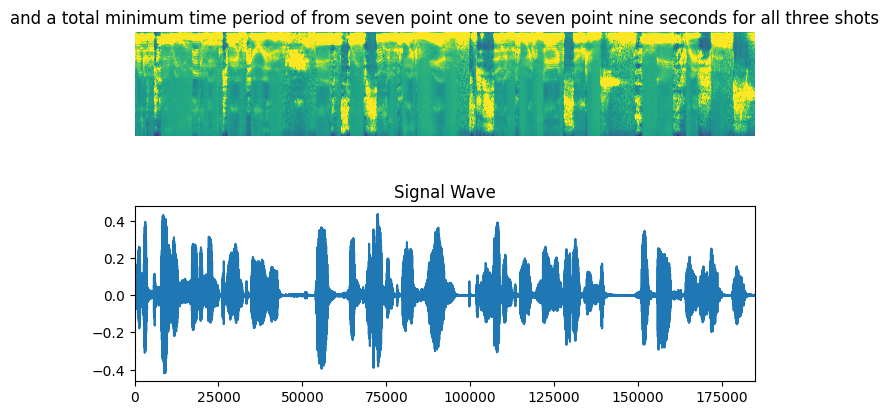

In [ ]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

# ASR Model

In [ ]:
# Define the CTC Loss function
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
def build_model(input_dim, output_dim, rnn_layers=2, rnn_units=64):
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

In [ ]:
# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary()

Model: "DeepSpeech_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 193)]       0         
                                                                 
 expand_dim (Reshape)        (None, None, 193, 1)      0         
                                                                 
 conv_1 (Conv2D)             (None, None, 97, 32)      14432     
                                                                 
 conv_1_bn (BatchNormalizat  (None, None, 97, 32)      128       
 ion)                                                            
                                                                 
 conv_1_relu (ReLU)          (None, None, 97, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, None, 49, 32)      236544    
                                                      

# Model Training and Evaluation

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [ ]:
# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [ ]:
# Define the number of epochs.
epochs = 10

# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/10
1/1 [==============================] - 1s 1s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------
Target    : the position of the page on the paper should be considered if the book is to have a satisfactory look
Prediction: 
----------------------------------------------------------------------------------------------------
Target    : his defense being that he had intended to commit suicide but that on the appearance of this officer who had wronged him
Prediction: 
----------------------------------------------------------------------------------------------------
141/141 [==============================] - 1132s 8s/step - loss: 331.0342 - val_loss: 438.6344
Epoch 2/10
1/1 [==============================] - 0s 251ms/step
--------------------------------------------------------------------------------

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)

wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 0s 254ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.7402
----------------------------------------------------------------------------------------------------
Target    : and it stated that mrs turner had been stricken with paralysis
Prediction: and it stated that ms turner had benstrcan with prralasis
----------------------------------------------------------------------------------------------------
Target    : it was not a standard type bag which could be obtained in a store and it was presumably made for a particular purpose
Prediction: i was no  stander ti ba wich cobe atnd an a stor and i was presimaly mad for a prticul ar perps
----------------------------------------------------------------------------------------------------
Target    : special agent lawson made certain that the dallas police kept the public and press away from the immediate area of the hospi

# Save model

In [ ]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras
'/content/model.h5' '/content/ctc_model'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 51.6 MB/s eta 0:00:00
2023-12-17 08:59:14.341483: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 08:59:14.341545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 08:59:14.342891: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 08:59:15.320041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter

'/content/model.h5/content/ctc_model'

In [ ]:
model.save('ctc_model.keras')

In [ ]:
model.save('ctc_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Inference

In [ ]:
!pip3 install -q SoundFile

In [ ]:
# Upload a pre-recorded audio file to Colab
from google.colab import files
import numpy as np
import soundfile as sf

uploaded = files.upload()

# Load the uploaded audio file
uploaded_filename = list(uploaded.keys())[0]
data, samplerate = sf.read(uploaded_filename)
sf.write('new_file.wav', data, samplerate)

# 1. Read wav file
file = tf.io.read_file("new_file.wav")
# 2. Decode the wav file
audio, _ = tf.audio.decode_wav(file)
audio = tf.squeeze(audio, axis=-1)
# 3. Change type to float
audio = tf.cast(audio, tf.float32)
# 4. Get the spectrogram
spectrogram = tf.signal.stft(
    audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
)
# 5. We only need the magnitude, which can be derived by applying tf.abs
spectrogram = tf.abs(spectrogram)
spectrogram = tf.math.pow(spectrogram, 0.5)
# 6. normalization
means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
spectrogram = (spectrogram - means) / (stddevs + 1e-10)
# Reshape
spectrogram = tf.expand_dims(spectrogram, axis=0)
print(spectrogram)

prediction = model.predict(spectrogram)
prediction = decode_batch_predictions(prediction)
print(prediction)

Saving data_SA2.wav to data_SA2.wav
tf.Tensor(
[[[ 4.5025854   3.2982934   0.89970577 ... -0.51082593 -0.07805765
    0.15319891]
  [ 6.8206987   5.7316756   3.2043624  ... -0.02779558  0.14622064
    0.06822406]
  [ 7.4072595   5.909737    1.7018164  ... -0.5740599  -0.80931234
   -0.831901  ]
  ...
  [ 1.128196    1.5961508   1.5282389  ...  0.16671368 -0.47673392
   -1.4604421 ]
  [ 5.6624627   5.5652356   5.033948   ... -0.5649155  -0.20474796
   -0.09554472]
  [ 5.3119793   5.454315    4.7058916  ... -1.0980961  -0.20543124
    0.05562863]]], shape=(1, 293, 193), dtype=float32)
1/1 [==============================] - 0s 144ms/step
[' hurl  r o o']
